In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
from utils import imageUtils, postProcessing

In [3]:
import numpy as np
import os

from skimage import exposure
import cv2
import chainer
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

root = '/home/wei/Data/Loop_detection'

In [186]:
from chainercv.visualizations import vis_bbox

In [187]:
from utils import DefectDetectionDataset

In [188]:
dataset = DefectDetectionDataset.DefectDetectionDataset(split='train')

In [189]:
dataset_test = DefectDetectionDataset.DefectDetectionDataset(split='test')

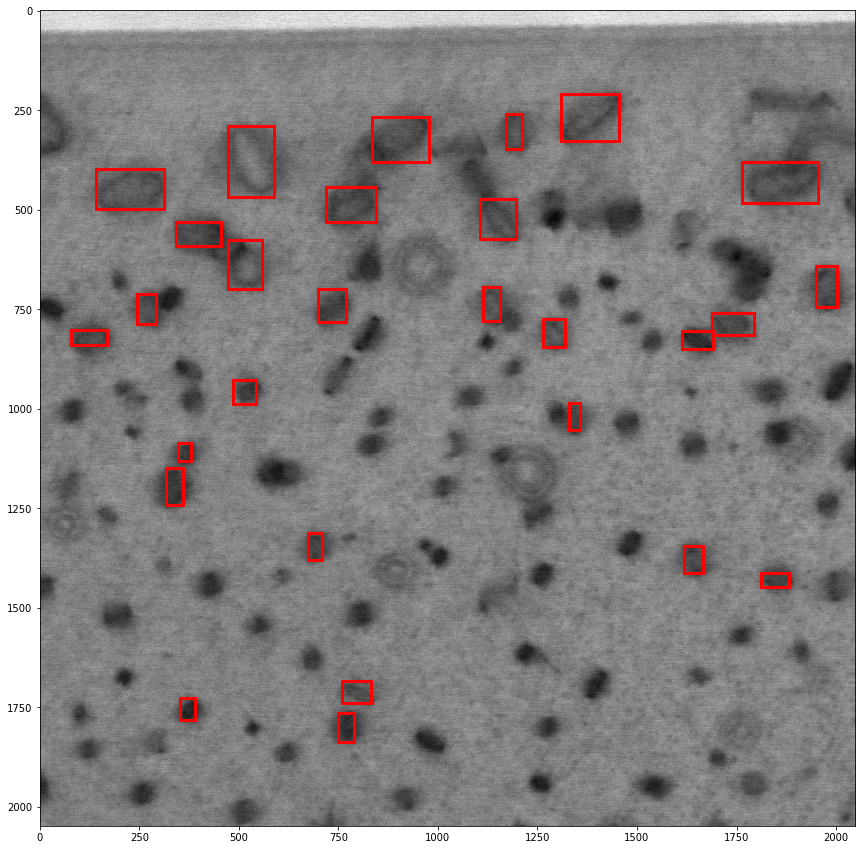

In [8]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[200]
vis_bbox(img, bbox, label, ax=ax1)
plt.show()

# Training RCNN

In [96]:
import numpy as np

import chainer
from chainer.datasets import ConcatenatedDataset
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger

from chainercv.datasets import voc_bbox_label_names
from chainercv.datasets import VOCBboxDataset
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms


class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

In [109]:
bbox_label_names = ('loop')

In [ ]:
np.random.seed(0)
train_data = DefectDetectionDataset.DefectDetectionDataset()
test_data = DefectDetectionDataset.DefectDetectionDataset()
faster_rcnn = FasterRCNNVGG16(n_fg_class=1,pretrained_model='imagenet')
faster_rcnn.use_preset('evaluate')
model = FasterRCNNTrainChain(faster_rcnn)
chainer.cuda.get_device_from_id(0).use()
model.to_gpu()
optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))
train_data = TransformDataset(train_data, Transform(faster_rcnn))
train_iter = chainer.iterators.SerialIterator(
    train_data, batch_size=1)
test_iter = chainer.iterators.SerialIterator(
    test_data, batch_size=1, repeat=False, shuffle=False)
updater = chainer.training.updater.StandardUpdater(
    train_iter, optimizer, device=0)
trainer = training.Trainer(
    updater, (700, 'iteration'), out='result')
trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model.npz'),
    trigger=(700, 'iteration'))
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(500, 'iteration'))
log_interval = 3, 'iteration'
plot_interval = 100, 'iteration'
print_interval = 3, 'iteration'
trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
     ]), trigger=print_interval)
trainer.extend(extensions.ProgressBar(update_interval=2))
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss'],
            file_name='loss.png', trigger=plot_interval
        ),
        trigger=plot_interval
    )
  
trainer.extend(
    DetectionVOCEvaluator(
        test_iter, model.faster_rcnn, use_07_metric=True,
        label_names=voc_bbox_label_names),
    trigger=ManualScheduleTrigger(
        [500, 700], 'iteration'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.run()

# Testing

In [190]:
from chainercv.links import FasterRCNNVGG16
bbox_label_names = ('loop')

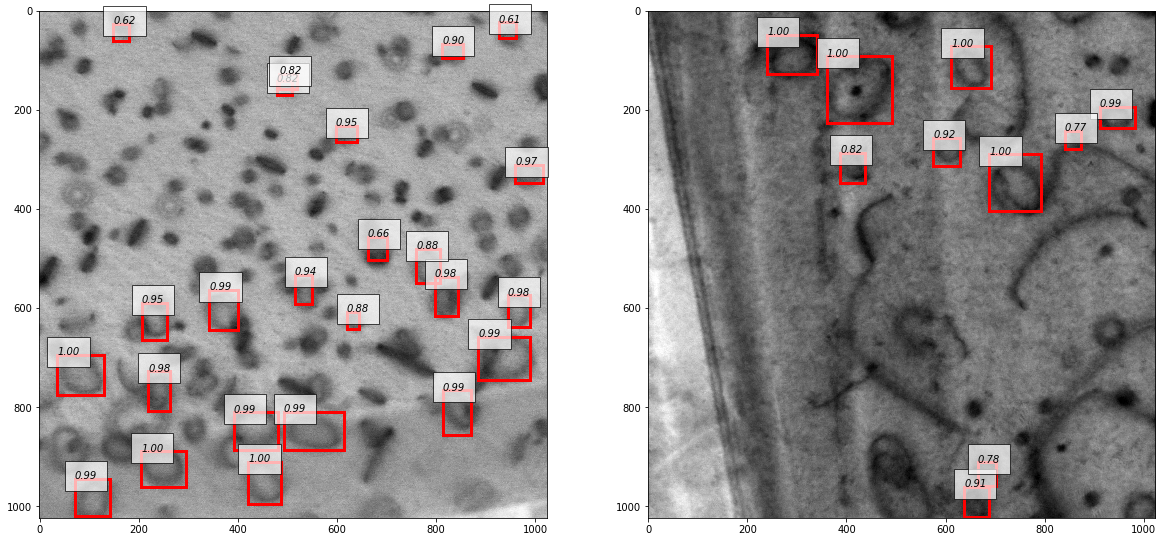

In [191]:
img_0, bbs_1, _ = dataset_test[3]
img_1, bbs_2, _ = dataset_test[14]
model = FasterRCNNVGG16(n_fg_class=1, pretrained_model='result/snapshot_model_70000.npz')
chainer.cuda.get_device_from_id(0).use()
model.to_gpu()
model.score_thresh = 0.6
# Note that `predict` takes a list of images.
bboxes, labels, scores = model.predict([img_0, img_1])

# Visualize output of the first image on the left and
# the second image on the right.
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bboxes[0], labels[0], scores[0], ax=ax1)
vis_bbox(img_1, bboxes[1], labels[1], scores[1], ax=ax2)
plt.show()

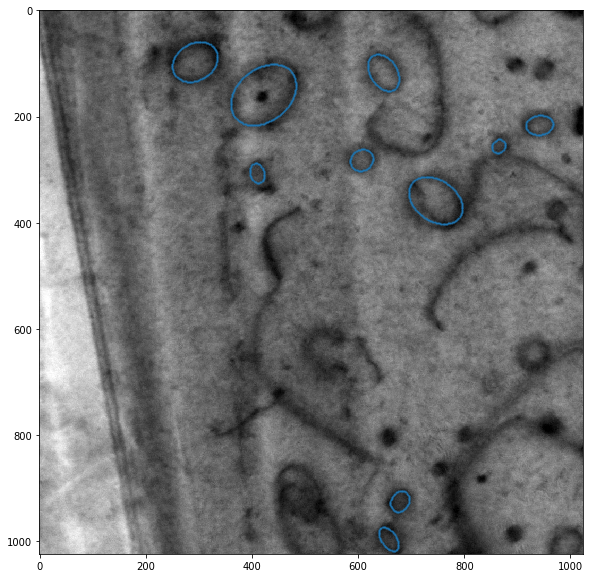

In [193]:
postProcessing.img_ellipse_fitting(img_1,bboxes[1])

In [9]:
img_0, bbs_1, _ = dataset_test[3]

In [10]:
subimages = imageUtils.cropImage(img_0,bbs_1)

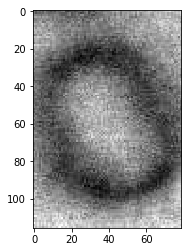

In [11]:
imageUtils.showImage(subimages[6])

In [166]:
a = np.concatenate((np.array([]),rr))

In [167]:
a.shape

(200,)

In [158]:
rr.shape

(200,)

In [156]:
a+rr

array([150, 147, 144, 141, 138, 135, 132, 129, 126, 123, 120, 117, 114,
       111, 108, 105, 102,  99,  96,  93,  90,  87,  84,  81,  78,  75,
        72,  72,  69,  69,  66,  66,  66,  66,  63,  63,  63,  63,  63,
       150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186,
       189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225,
       228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264,
       267, 270, 273, 276, 276, 279, 282, 282, 285, 285, 288, 288, 288,
       291, 291, 291, 291, 294, 294, 294, 294, 294, 207, 210, 213, 216,
       219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255,
       258, 261, 264, 267, 270, 273, 276, 279, 282, 285, 285, 288, 288,
       291, 291, 291, 291, 294, 294, 294, 294, 294, 207, 204, 201, 198,
       195, 192, 189, 186, 183, 180, 177, 174, 171, 168, 165, 162, 159,
       156, 153, 150, 147, 144, 141, 138, 135, 132, 129, 126, 123, 120,
       117, 114, 111, 108, 105, 102,  99,  96,  93,  90,  87,  8

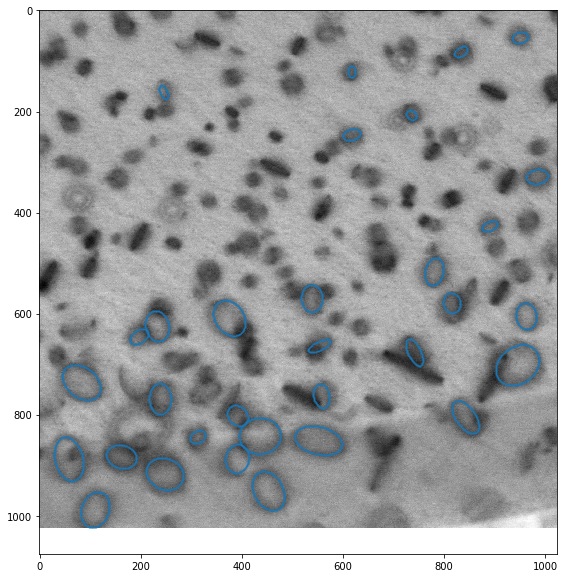

In [184]:
postProcessing.img_ellipse_fitting(img_0,bbs_1)

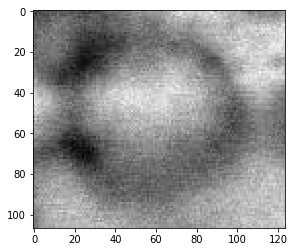

In [145]:
imageUtils.showImage(subimages[0])

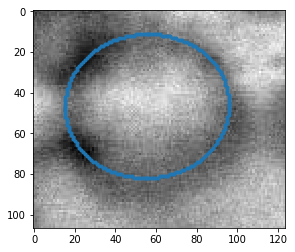

In [146]:
postProcessing.show_fitted_ellipse(subimages[0])

In [12]:
from chainercv.utils import write_image
import math

In [161]:
write_image(subimages[6], "./subimage6.jpg")

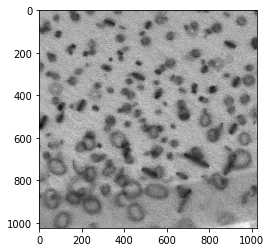

In [22]:
plt.imshow(img_0.transpose((1,2,0))[:,:,2], cmap='gray')

In [13]:
subim = cv2.imread('subimage6.jpg')

In [14]:
subim_gray = subim[:,:,1]

In [15]:
h, w = subim_gray.shape

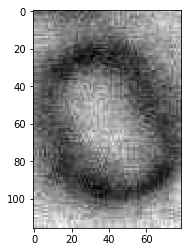

In [16]:
plt.imshow(subim_gray, cmap='gray')

In [24]:
img1 = exposure.equalize_hist(subim_gray)

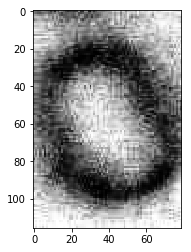

In [25]:
plt.imshow(img1, cmap='gray')

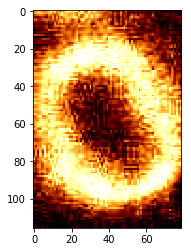

In [26]:
img2 = np.max(img1) - img1
plt.imshow(img2, cmap='afmhot')

In [109]:
from skimage import morphology, measure, draw

In [59]:
labels = morphology.watershed(img1, markers)

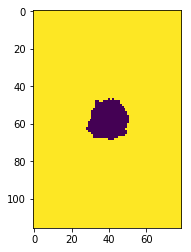

In [60]:
plt.imshow(labels)

In [78]:
inner = np.zeros((h, w), np.bool)
inner[round(h/2), round(w/2)] = 1
min_size = round((h + w) / 20)
kernel = morphology.disk(min_size)
inner = morphology.dilation(inner, kernel)
out = np.zeros((h,w), np.bool)
out[0,0] = 1
out[h-1,0] = 1
out[0,w-1] = 1
out[h-1,w-1] = 1
out = morphology.dilation(out, kernel)

In [79]:
markers = np.zeros((h,w), np.int)
markers[inner] = 2
markers[out] = 1

In [80]:
labels = morphology.watershed(img2, markers)

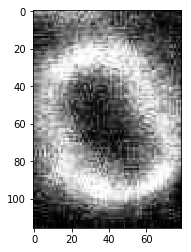

In [81]:
plt.imshow(img2,cmap='gray')

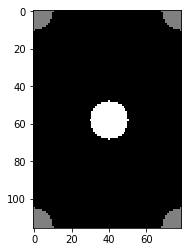

In [82]:
plt.imshow(markers, cmap='gray')

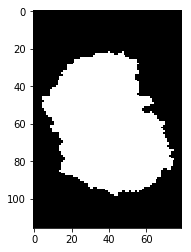

In [85]:
plt.imshow(labels, cmap='gray')

In [104]:
results = measure.regionprops(labels-1)
sorted(results, key=lambda k:k['area'])

In [105]:
region1 = results[0]

In [118]:
int(3.5)

3

In [117]:
round(region1['centroid'][0]), round(region1['centroid'][1]), round(region1['minor_axis_length']/2),round(region1['major_axis_length']/2), round(region1['orientation'])

(61.0, 39.0, 29, 40, -1)

In [125]:
rr,cc = draw.ellipse_perimeter(int(region1['centroid'][0]), int(region1['centroid'][1]), int(region1['minor_axis_length']/2), 
             int(region1['major_axis_length']/2), -region1['orientation'],labels.shape)

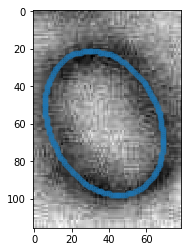

In [181]:
fig = plt.figure()
plt.imshow(subim_gray,cmap='gray')
plt.scatter(cc,rr,s=(5*72./fig.dpi)**2,alpha=0.5)

In [107]:
for prop in region1:
    print(prop)

area
bbox
bbox_area
centroid
convex_area
convex_image
coords
eccentricity
equivalent_diameter
euler_number
extent
filled_area
filled_image
image
label
major_axis_length
minor_axis_length
moments
moments_central
moments_hu
moments_normalized
orientation
perimeter
solidity


In [40]:
markers = np.zeros((h, w), np.int32)

In [41]:
markers[math.floor(h/2-5):math.ceil(h/2+5),math.floor(w/2-5):math.ceil(w/2+5)] = 1

In [42]:
markers[0,:]=2
markers[:,0]=2
markers[h-1,:]=2
markers[:,w-1]=2

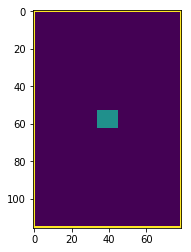

In [43]:
plt.imshow(markers)

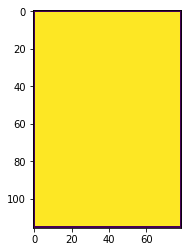

In [36]:
plt.imshow(markers)

In [47]:
bbox = bbs_1[2,:]
bbox = bbox.astype(int)

In [48]:
image = img_0[:,bbox[0]:bbox[2], bbox[1]:bbox[3]]

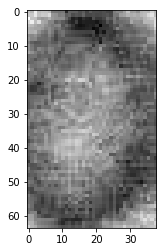

In [49]:
imageUtils.showImage(image)

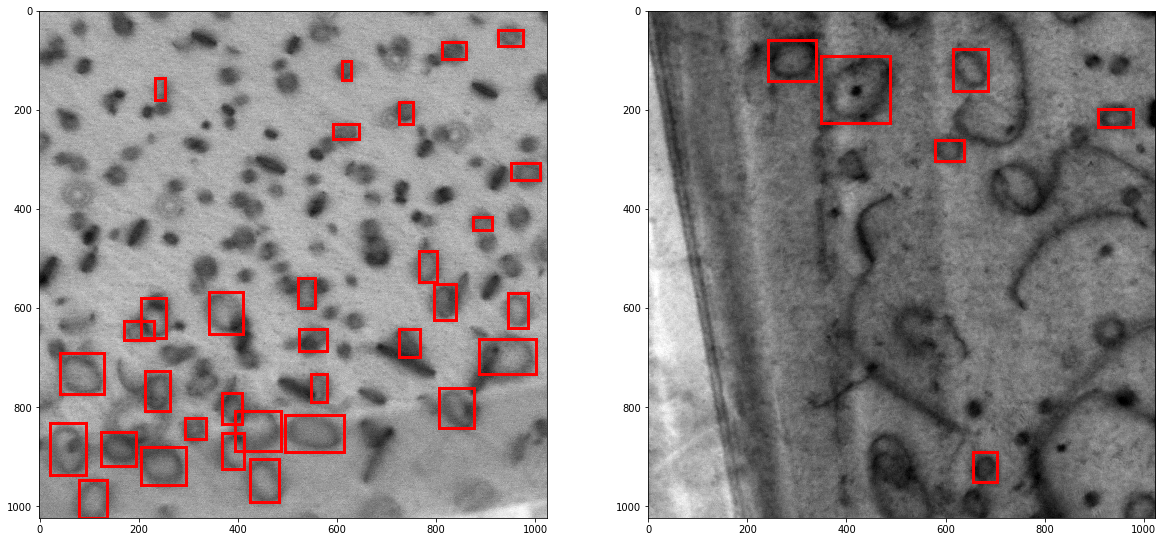

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
vis_bbox(img_0, bbs_1, ax=ax1)
vis_bbox(img_1, bbs_2, ax=ax2)
plt.show()

In [19]:
data_dir = root
images_file = os.path.join(data_dir, 'images.txt')
f = open(images_file)

In [20]:
images = [line.strip() for line in f]

In [38]:
bbs_file = os.path.join(root, "bounding_boxes", str('0501_300kx_1nm_clhaadf3_0031.jpg'[0:-4] +'.txt'))

In [47]:
bbs = np.stack([line.strip().split() for line in open(bbs_file)]).astype(np.float32)

In [48]:
bbs.shape

(7, 4)

In [52]:
np.stack([1]*bbs.shape[0]).astype(np.int32)

array([1, 1, 1, 1, 1, 1, 1], dtype=int32)